In [1]:
import pandas as pd
import numpy as np
import os
import re
import time
import threading
import subprocess
from glob import glob
from IPython.display import clear_output

from tqdm.notebook import tqdm
from pqdm.threads import pqdm
from rdkit import Chem
from rdkit.Chem import Descriptors, Descriptors3D, ChemicalFeatures, GraphDescriptors, Lipinski, rdchem
from rdkit.Chem.rdchem import Mol, Atom, Bond
from rdkit.Chem.rdmolfiles import SDMolSupplier, SDWriter
from openbabel import pybel
import xyz2mol

if not os.path.exists('./temp'):
    os.mkdir('./temp')

In [2]:
def in_ipython():
    try:
        return __IPYTHON__
    except NameError:
        return False

In [3]:
xyz_filepath_list = list(glob('./data/*.xyz'))

xyz_filepath_list.sort()
print('total xyz filepath # ', len(xyz_filepath_list))

molecules = []

for m in tqdm(xyz_filepath_list):
    with open(m) as file:
        lines = file.readlines()

        smiles = lines[len(lines) - 2].split()[0]

        molecules.append(Chem.MolFromSmiles(smiles))

total xyz filepath #  133885


  0%|          | 0/133885 [00:00<?, ?it/s]

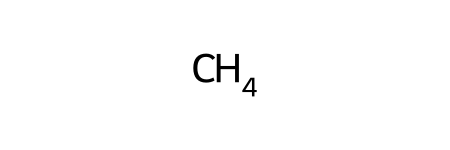

In [4]:
molecules[0]

In [5]:
df_list = []
main_df = None
line_split_re = re.compile(r'\s+')


def preprocess():
    temp_path = './temp/'

    if not os.path.exists(temp_path):
        os.mkdir(temp_path)

    for mol in tqdm(molecules):
        if mol is None:
            continue

        mol = Chem.AddHs(mol)

        Mol.Compute2DCoords(mol)
        Mol.ComputeGasteigerCharges(mol)

        df_out = None

        with open(temp_path + 'mol.sdf', 'w') as file:
            Chem.MolToPDBFile(mol, temp_path + 'mol.sdf')

        # Run antechamber and divert output to a file (temporary)
        subprocess.getoutput(
            f'cd {temp_path} && antechamber -i mol.sdf -fi pdb -o mol.ac -fo ac -at gaff2 -pf y'
        )

        rdInfo = {}

        rdInfo['hvyAtCnt'] = Lipinski.HeavyAtomCount(mol)
        rdInfo['nhohC'] = Lipinski.NHOHCount(mol)
        rdInfo['noC'] = Lipinski.NOCount(mol)
        rdInfo['aliCC'] = Lipinski.NumAliphaticCarbocycles(mol)
        rdInfo['aliHC'] = Lipinski.NumAliphaticHeterocycles(mol)
        rdInfo['aliR'] = Lipinski.NumAliphaticRings(mol)
        rdInfo['aroCC'] = Lipinski.NumAromaticCarbocycles(mol)
        rdInfo['aroR'] = Lipinski.NumAromaticRings(mol)
        rdInfo['HA'] = Lipinski.NumHAcceptors(mol)
        rdInfo['HD'] = Lipinski.NumHDonors(mol)
        rdInfo['HAt'] = Lipinski.NumHeteroatoms(mol)
        rdInfo['rotatableBonds'] = Lipinski.NumRotatableBonds(mol)
        rdInfo['satCC'] = Lipinski.NumSaturatedCarbocycles(mol)
        rdInfo['satHC'] = Lipinski.NumSaturatedHeterocycles(mol)
        rdInfo['satR'] = Lipinski.NumSaturatedRings(mol)
        rdInfo['rC'] = Lipinski.RingCount(mol)
        rdInfo['molWt'] = Descriptors.MolWt(mol)
        rdInfo['hvyAtMolWt'] = Descriptors.HeavyAtomMolWt(mol)
        rdInfo['molMaxPC'] = Descriptors.MaxPartialCharge(mol)
        rdInfo['molMinPC'] = Descriptors.MinPartialCharge(mol)
        rdInfo['molRadElec'] = Descriptors.NumRadicalElectrons(mol)
        rdInfo['molValElec'] = Descriptors.NumValenceElectrons(mol)
        rdInfo['asph'] = Descriptors3D.Asphericity(mol)
        rdInfo['ecc'] = Descriptors3D.Eccentricity(mol)
        rdInfo['isf'] = Descriptors3D.InertialShapeFactor(mol)
        rdInfo['npr1'] = Descriptors3D.NPR1(mol)
        rdInfo['npr2'] = Descriptors3D.NPR2(mol)
        rdInfo['pmi'] = Descriptors3D.PMI1(mol)
        rdInfo['rog'] = Descriptors3D.RadiusOfGyration(mol)
        rdInfo['j'] = GraphDescriptors.BalabanJ(mol)
        rdInfo['ct'] = GraphDescriptors.BertzCT(mol)

        with open(temp_path + 'mol.ac') as file:
            lines = [a for a in file.readlines() if 'ATOM' in a]

            for atom in Mol.GetAtoms(mol):
                out = {}

                idx = Atom.GetIdx(atom)

                line = lines[idx]

                a_split = line_split_re.split(line.strip())
                atom_name = a_split[2]
                if len(a_split) > 9:
                    atom_type = a_split[9]
                else:
                    atom_type = a_split[8]

                out['type'] = atom_type
                out['name'] = Atom.GetSymbol(atom)

                # print(f'RDKit atom: {Atom.GetSymbol(atom)}')
                # print(f'antechamber atom: {atom_name}')

                bonds = {
                    'C': 0,
                    'H': 0,
                    'N': 0,
                    'O': 0,
                    'S': 0,
                    'F': 0,
                    'Cl': 0,
                    'Br': 0,
                    'I': 0,
                    'Other': 0
                }

                bond_types = {
                    'SINGLE': 0,
                    'DOUBLE': 0,
                    'TRIPLE': 0,
                    'OTHER': 0
                }

                args = {
                    'depDeg': Atom.GetDegree(atom),
                    'explVal': Atom.GetExplicitValence(atom),
                    'forC': Atom.GetFormalCharge(atom),
                    'implV': Atom.GetImplicitValence(atom),
                    'isA': int(Atom.GetIsAromatic(atom)),
                    'explH': Atom.GetNumExplicitHs(atom),
                    'implH': Atom.GetNumImplicitHs(atom),
                    'radEl': Atom.GetNumRadicalElectrons(atom),
                    'totDeg': Atom.GetTotalDegree(atom),
                    'totH': Atom.GetTotalNumHs(atom),
                    'totV': Atom.GetTotalValence(atom),
                    'isR': Atom.IsInRing(atom),
                }

                for bond in Atom.GetBonds(atom):
                    bond_name = Atom.GetSymbol(Bond.GetEndAtom(bond))
                    bond_type = Bond.GetBondType(bond)

                    if bond_name in bonds.keys():
                        bonds[bond_name] += 1
                    else:
                        bonds['Other'] += 1

                    if bond_type in bond_types.keys():
                        bond_types[bond_type] += 1
                    else:
                        bond_types['OTHER'] += 1

                out.update(bonds)
                out.update(bond_types)
                out.update(rdInfo)
                out.update(args)

                # Append molecule info to every atom
                atom_df = pd.DataFrame(out, index=[0])

                if df_out is None:
                    df_out = pd.DataFrame(columns=atom_df.columns)

                df_out = pd.concat([df_out, atom_df], ignore_index=True)

        # Clean up remaining files
        try:
            os.remove(temp_path + 'mol.ac')
            os.remove(temp_path + 'mol.sdf')
        except IOError:
            print('Something went wrong.')

        df_list.append(df_out)

In [6]:
class PreprocessingThread(threading.Thread):
    def __init__(self, file_name):
        threading.Thread.__init__(self)
        self.file_name = file_name

    def run(self):
        print("Starting " + self.file_name)
        preprocess(self.file_name)
        print("Exiting " + self.file_name)

In [7]:
def main():
    preprocess()

    # Concatenate dfs in the list
    main_df = pd.concat(df_list, ignore_index=True)
    main_df.to_csv('./data/data.csv', index=False)

In [ ]:
if __name__ == "__main__":
    if not in_ipython():
        root_dir = os.path.dirname(os.path.realpath(__file__))

        main()
    else:
        main()

  0%|          | 0/133885 [00:00<?, ?it/s]